[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/dgomes03/FIRE-HACK-Project/blob/main/RFR_model.ipynb)

In [16]:
import pandas as pd
import numpy as np
import warnings
from dbfread import DBF
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV, TimeSeriesSplit
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from scipy.stats import randint, uniform
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import IsolationForest
from sklearn.model_selection import train_test_split
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import HalvingRandomSearchCV

### Load data

In [ ]:
# Load dataset from DBF file
print("Loading dataset...")

try:
    csv_path = 'PT-FireProg_v2.1_L2_p_meteo.csv'
    df = pd.read_csv(csv_path)

except Exception as e:
    print(f"Error loading dataset: {e}")
    raise

Loading dataset...


### Clean and filter data

In [18]:
# Remove rows with missing dates and keep only fire_front_rank 0 and 1
df_clean = df.replace('na', pd.NA).dropna(subset=['sdate', 'edate'])

# Only keep fire fronts with rank 0 or 1 for modeling
if 'fire_front_rank' in df_clean.columns:
    df_clean = df_clean[df_clean['fire_front_rank'].isin([0, 1])].copy()

# Convert dates and sort
df_clean['sdate'] = pd.to_datetime(df_clean['sdate'], errors='coerce')
df_clean = df_clean.dropna(subset=['sdate']).sort_values(['fname', 'sdate']).reset_index(drop=True)

### Imputation and Outlier removal

In [19]:
# Handle missing values in df_clean
print("Checking for missing values before imputation...")
missing_stats = df_clean.isnull().sum()
print("\nMissing values by column:")
print(missing_stats[missing_stats > 0])

# Separate numerical and categorical columns
numeric_cols = df_clean.select_dtypes(include=['int64', 'float64']).columns
categorical_cols = df_clean.select_dtypes(include=['object', 'category']).columns

############ ALTERAR ISTO NO FUTURO. PODERA SER PRECISO CRIAR IMPUTACAO NAS COLUNAS ABAIXO ########
exclude_cols = ['LFC_hPa_av', 'LFC_hPa_mn', 'LFC_hPa_mx', 'CCL_hPa_av', 'CCL_hPa_mn', 'CCL_hPa_mx', 'EL_m_av', 'EL_m_mn', 'EL_m_mx', 'Cin_av', 'Cin_mn', 'Cin_mx']

# For numeric columns - use median imputation
for col in numeric_cols:
    if col in exclude_cols:
        print(f"Skipping column '{col}' (excluded from imputation).")
        continue

    if df_clean[col].isnull().any():
        median_val = df_clean[col].median()
        df_clean[col].fillna(median_val, inplace=True)
        print(f"Imputed NUMERIC column '{col}' with median value: {median_val:.4f}")

# For categorical columns - use mode imputation
for col in categorical_cols:
    if df_clean[col].isnull().any():
        mode_val = df_clean[col].mode()[0]
        df_clean[col].fillna(mode_val, inplace=True)
        print(f"Imputed CATEGORICAL column '{col}' with mode value: {mode_val}")

# Verify no missing values remain
print("\nChecking for missing values after imputation...")
missing_stats_after = df_clean.isnull().sum()
remaining_missing = missing_stats_after[missing_stats_after > 0]

if remaining_missing.empty:
    print("No remaining missing values.")
else:
    print("\nRemaining missing values by column:")
    print(remaining_missing)

# Remove outliers from 'ros_p' using Isolation Forest
# Ensure 'ros_p' exists and has no NaNs
if 'ros_p' not in df_clean.columns:
    raise KeyError("'ros_p' column not found in df_clean.")
if df_clean['ros_p'].isnull().any():
    raise ValueError("'ros_p' contains NaN values. Please impute or remove them before running Isolation Forest.")

# Reshape for model
ros_p_values = df_clean['ros_p'].values.reshape(-1, 1)

# Initialize Isolation Forest
iso_forest = IsolationForest(
    contamination=0.08,
    random_state=42,
    n_estimators=200
)

# Fit and predict
outlier_pred = iso_forest.fit_predict(ros_p_values)

# -1 = outlier, 1 = inlier
df_clean['is_outlier'] = outlier_pred

# Count outliers
outliers_count = (df_clean['is_outlier'] == -1).sum()
print(f"Number of outliers detected: {outliers_count}")

# Filter outliers
df_clean = df_clean[df_clean['is_outlier'] == 1].copy()
df_clean.drop(columns=['is_outlier'], inplace=True)

print(f"New DataFrame size after Isolation Forest filtering: {len(df_clean)} rows.")

Checking for missing values before imputation...

Missing values by column:
source          1
CBH_m_av      857
CBH_m_mn      857
CBH_m_mx      857
HigCC_p_av    102
             ... 
wv100_k_mx    102
wv100_k_mn    102
Recirc         99
CircVar        14
CircStd_dg     14
Length: 120, dtype: int64
Imputed NUMERIC column 'CBH_m_av' with median value: 3977.1796
Imputed NUMERIC column 'CBH_m_mn' with median value: 3543.3969
Imputed NUMERIC column 'CBH_m_mx' with median value: 4334.6290
Imputed NUMERIC column 'HigCC_p_av' with median value: 0.0591
Imputed NUMERIC column 'HigCC_p_mn' with median value: 0.0000
Imputed NUMERIC column 'HigCC_p_mx' with median value: 0.1425
Imputed NUMERIC column 'LowCC_p_av' with median value: 0.0000
Imputed NUMERIC column 'LowCC_p_mn' with median value: 0.0000
Imputed NUMERIC column 'LowCC_p_mx' with median value: 0.0000
Imputed NUMERIC column 'MidCC_p_av' with median value: 0.0024
Imputed NUMERIC column 'MidCC_p_mn' with median value: 0.0000
Imputed NUMERIC

/var/folders/kd/4r8kz2pd215cjlt29s2n99vh0000gn/T/ipykernel_5033/532927986.py:22: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_clean[col].fillna(median_val, inplace=True)
/var/folders/kd/4r8kz2pd215cjlt29s2n99vh0000gn/T/ipykernel_5033/532927986.py:29: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always b

### Calculate duration in minutes since fire start

In [20]:
def calculate_fire_durations(df):
    df_temp = df.copy()
    
    # 1. Convert sdate to datetime
    df_temp['sdate'] = pd.to_datetime(df_temp['sdate'], errors='coerce')
    
    # 2. Sort by fire name and date
    df_temp = df_temp.sort_values(by=['fname', 'sdate'])
    
    # 3. Calculate 'duration' (time since the start of the fire)
    fire_start_times = df_temp.groupby('fname')['sdate'].transform('min')
    df_temp['duration'] = (df_temp['sdate'] - fire_start_times).dt.total_seconds() / 60
    
    # 4. Calculate lag features as time differences between consecutive observations
    # Group by fname and calculate time differences between rows
    time_diffs = df_temp.groupby('fname')['sdate'].diff().dt.total_seconds() / 60
    
    # Create lag features by shifting the time differences
    df_temp['duration_lag1'] = time_diffs
    df_temp['duration_lag2'] = df_temp.groupby('fname')['duration_lag1'].shift(1)
    df_temp['duration_lag3'] = df_temp.groupby('fname')['duration_lag1'].shift(2)
    
    return df_temp

# Apply the corrected function
df_processed = calculate_fire_durations(df_clean)

# --- Verification ---
print("\nVerifying calculation for 'Agueda_08082016':")
print(df_processed[df_processed['fname'] == 'Agueda_08082016'][
    ['fname', 'sdate', 'duration', 'duration_lag1', 'duration_lag2', 'duration_lag3']
].head(10))

print("\nVerifying calculation for 'Gouveia_10082015':")
print(df_processed[df_processed['fname'] == 'Gouveia_10082015'][
    ['fname', 'sdate', 'duration', 'duration_lag1', 'duration_lag2', 'duration_lag3']
].head(10))

df_with_ranks = df_processed
df_with_ranks.to_csv('/Users/diogogomes/Documents/Uni/Hackathon/models/durations.csv', index=False)

df_clean = df_with_ranks


Verifying calculation for 'Agueda_08082016':
              fname               sdate  duration  duration_lag1  \
23  Agueda_08082016 2016-08-08 04:00:00       0.0            NaN   
24  Agueda_08082016 2016-08-08 12:30:00     510.0          510.0   
25  Agueda_08082016 2016-08-10 13:30:00    3450.0         2940.0   

    duration_lag2  duration_lag3  
23            NaN            NaN  
24            NaN            NaN  
25          510.0            NaN  

Verifying calculation for 'Gouveia_10082015':
                fname               sdate  duration  duration_lag1  \
812  Gouveia_10082015 2015-08-10 14:30:00       0.0            NaN   
813  Gouveia_10082015 2015-08-11 03:00:00     750.0          750.0   
814  Gouveia_10082015 2015-08-11 12:30:00    1320.0          570.0   
815  Gouveia_10082015 2015-08-11 12:30:00    1320.0            0.0   

     duration_lag2  duration_lag3  
812            NaN            NaN  
813            NaN            NaN  
814          750.0            NaN  

### Select features for model

In [21]:
base_features = [
    't_2m_C_av','t_2m_C_mn','t_2m_C_mx',
    'd_2m_C_av','d_2m_C_mn','d_2m_C_mx',
    'rh_2m_av','rh_2m_mn','rh_2m_mx',
    'VPD_Pa_av','VPD_Pa_mn','VPD_Pa_mx',
    'wv10_kh_av','wv10_kh_mn','wv10_kh_mx','wdir10_av',
    'wv100_k_av','wv100_k_mn','wv100_k_mx','wdir100_av',
    'wS_v_av','wS_v_mn','wS_v_mx','wS_dir_av','wS_dir_mn','wS_dir_mx',
    'CBH_m_av','CBH_m_mn','CBH_m_mx',
    'HigCC_p_av','HigCC_p_mn','HigCC_p_mx',
    'LowCC_p_av','LowCC_p_mn','LowCC_p_mx',
    'MidCC_p_av','MidCC_p_mn','MidCC_p_mx',
    'TotCC_p_av','TotCC_p_mn','TotCC_p_mx',
    'BLH_m_av','BLH_m_mn','BLH_m_mx',
    'Cape_av','Cape_mn','Cape_mx',
    'Cin_av','Cin_mn','Cin_mx',
    'LCL_hPa_av','LCL_hPa_mn','LCL_hPa_mx',
    'Haines_av','Haines_mn','Haines_mx',
    'gp_m2s2_av','gp_m2s2_mn','gp_m2s2_mx',
    'sP_hPa_av','sP_hPa_mn','sP_hPa_mx',
    'dfmc_av','dfmc_mn','dfmc_mx',
    'Recirc','CircVar','CircStd_dg',
    'elev_av','aspect_av','landform', "land_use", "fuel_model", "duration", "fname", 'duration_lag1', 'duration_lag2', 'duration_lag3',
    'CMLG_av','CMLG_mn','CMLG_mx','LFC_hPa_av','LFC_hPa_mn','LFC_hPa_mx','EL_m_av','EL_m_mn','EL_m_mx','VentIdx_av','VentIdx_mn','VentIdx_mx',
    'LiftIdx_av','LiftIdx_mn','LiftIdx_mx', 'SBI_i_av','SBI_i_mn','SBI_i_mx','SBI_t_av','SBI_t_mn','SBI_t_mx','SBI_g_av','SBI_g_mn','SBI_g_mx',
    'EBI_i_av','EBI_i_mn','EBI_i_mx','EBI_t_av','EBI_t_mn','EBI_t_mx','EBI_g_av','EBI_g_mn','EBI_g_mx','EBI_bPL_av','EBI_bPL_mn','EBI_bPL_mx',
    'M_EBIs_av','M_EBIs_mn','M_EBIs_mx'
 ]

base_features = [c for c in base_features if c in df_clean.columns]

# Prepare target variable
df_clean['ros_p'] = pd.to_numeric(df_clean['ros_p'], errors='coerce')

# Filter columns that exist in df_clean (EXCLUDE sdate from features for modeling)
model_columns = [c for c in base_features if c in df_clean.columns] + ['ros_p']
df_clean = df_clean[model_columns + ['sdate']]

In [22]:
print(df_clean.head())

df_clean.to_csv('df_clean.csv', index=False)

   t_2m_C_av  t_2m_C_mn  t_2m_C_mx  d_2m_C_av  d_2m_C_mn  d_2m_C_mx  \
0  21.743764  19.144196  25.746490   6.639598   5.945953   7.067535   
1  18.237311  17.374420  19.144196   4.642242   3.418365   5.945953   
2  18.237311  17.374420  19.144196   4.642242   3.418365   5.945953   
3  28.874420  27.714264  29.926178   2.205800   1.846100   2.628815   
4  28.874420  27.714264  29.926178   2.205800   1.846100   2.628815   

    rh_2m_av   rh_2m_mn   rh_2m_mx    VPD_Pa_av  ...  EBI_g_mn  EBI_g_mx  \
0  37.942849  29.208778  42.053207  1645.136251  ...      -1.0      -1.0   
1  40.648228  39.374454  42.046818  1241.648340  ...      -1.0      -1.0   
2  40.648228  39.374454  42.046818  1241.648340  ...      -1.0      -1.0   
3  18.089512  16.545292  19.881321  3257.804281  ...      -1.0      -1.0   
4  18.089512  16.545292  19.881321  3257.804281  ...      -1.0      -1.0   

   EBI_bPL_av  EBI_bPL_mn  EBI_bPL_mx  M_EBIs_av  M_EBIs_mn  M_EBIs_mx  \
0        -1.0        -1.0        -1.0     

### Create fire lags

In [23]:
def create_fire_lags(df_data, columns_to_lag=["ros_p"], n_lags=10):
    df_combined = df_data.copy()
    
    # Sort by fire name and duration to ensure correct temporal order
    df_combined = df_combined.sort_values(['fname', 'duration']).reset_index(drop=True)
    
    # Create lags for each specified column
    for col in columns_to_lag:
        if col not in df_combined.columns:
            print(f"Warning: Column '{col}' not found in dataframe. Skipping.")
            continue
        
        for lag in range(1, n_lags + 1):
            lag_col_name = f'{col}_lag{lag}'
            
            # Create lag within each fire group
            df_combined[lag_col_name] = df_combined.groupby('fname')[col].shift(lag)
            
            # Set lag to NaN for rows where current duration=0
            df_combined.loc[df_combined['duration'] == 0, lag_col_name] = np.nan
    
    return df_combined

# Apply lag creation to df_clean
df_clean = create_fire_lags(df_clean)
df_clean.to_csv('df_clean.csv', index=False)

print("Lags added to df_clean")
print(f"df_clean shape: {df_clean.shape}")
print(f"Columns with lags: {[col for col in df_clean.columns if 'lag' in col]}")

# Display first few rows to verify
print("\nFirst few rows of fire (showing lag columns):")
lag_cols = [col for col in df_clean.columns if 'lag' in col]
print(df_clean[['fname', 'duration', 'CircStd_dg', 'CircVar', 'Recirc', 'ros_p'] + lag_cols].head(10))

Lags added to df_clean
df_clean shape: (1577, 129)
Columns with lags: ['duration_lag1', 'duration_lag2', 'duration_lag3', 'ros_p_lag1', 'ros_p_lag2', 'ros_p_lag3', 'ros_p_lag4', 'ros_p_lag5', 'ros_p_lag6', 'ros_p_lag7', 'ros_p_lag8', 'ros_p_lag9', 'ros_p_lag10']

First few rows of fire (showing lag columns):
               fname  duration    CircStd_dg   CircVar    Recirc        ros_p  \
0  Abrantes_09082017       0.0  6.084111e+00  0.005622  0.005230  1199.641053   
1  Abrantes_09082017     300.0  1.240214e+01  0.023155  0.023206   397.497644   
2  Abrantes_09082017     300.0  1.240214e+01  0.023155  0.023206   248.620331   
3  Abrantes_09082017    1080.0  1.077026e+01  0.017512  0.017489   613.820792   
4  Abrantes_09082017    1080.0  1.077026e+01  0.017512  0.017489  1092.753836   
5  Abrantes_09082017    1230.0  2.162422e+01  0.068744  0.060575   228.912880   
6  Abrantes_09082017    1230.0  2.152681e+01  0.068147  0.059526   584.937417   
7  Abrantes_29082023       0.0  8.537736e-

### Turn ros lags into log

In [24]:
# Identify only ros_p lag columns
ros_lag_cols = [col for col in df_clean.columns if col.startswith('ros_p_lag')]

# Apply log transformation only to ros_p lag columns
for col in ros_lag_cols:
    log_col = f'{col}_log'
    df_clean[log_col] = np.where(
        df_clean[col] > 0,
        np.log(df_clean[col]),
        np.nan  # avoid log(0) or negative values
    )

df_clean.drop(columns=ros_lag_cols, inplace=True)

### Create test and train datasets

In [25]:
# -----------------------------------------
# Random 80/20 Train-Test Split
# -----------------------------------------

df_train, df_test = train_test_split(
    df_clean,
    test_size=0.2,
    shuffle=True,
    random_state=42
)

# Reset indices
df_train = df_train.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

# -----------------------------------------
# Features and Target
# -----------------------------------------

# Drop or exclude columns that shouldn't be features
selected_cols = [c for c in df_clean.columns if c not in ['sdate', 'ros_p']]

# Define X and y for both splits
X_train = df_train[selected_cols].copy()
X_test = df_test[selected_cols].copy()
y_train = df_train['ros_p'].copy()
y_test = df_test['ros_p'].copy()

# -----------------------------------------
# Summary
# -----------------------------------------
print("Training set size:", len(X_train))
print("Test set size:", len(X_test))

# -----------------------------------------
# Prepare feature and target DataFrames
# -----------------------------------------
feature_columns = X_train.columns.tolist()

# Remove invalid targets (-1 values)
valid_train = y_train != -1
valid_test = y_test != -1

X_train_final = X_train[valid_train].reset_index(drop=True)
y_train_final = y_train[valid_train].reset_index(drop=True)

X_test_final = X_test[valid_test].reset_index(drop=True)
y_test_final = y_test[valid_test].reset_index(drop=True)

print(f"\nRows removed due to invalid target (-1):")
print(f"  Train: {(~valid_train).sum()} rows removed, {len(X_train_final)} final rows")
print(f"  Test: {(~valid_test).sum()} rows removed, {len(X_test_final)} final rows")

# Verify no NaN values remain
print(f"\nFinal verification - NaN values remaining:")
print(f"  X_train_final: {X_train_final.isna().sum().sum()}")
print(f"  X_test_final: {X_test_final.isna().sum().sum()}")
print(f"  y_train_final: {pd.isna(y_train_final).sum()}")
print(f"  y_test_final: {pd.isna(y_test_final).sum()}")

# Prepare final datasets for modeling (remove non-feature columns)
X_train_final = X_train_final.drop(columns=["fname"])
X_test_final = X_test_final.drop(columns=["fname"])

# Save datasets
X_train_final.to_csv('X_train_with_lags.csv', index=False)
y_train_final.to_csv('y_train_with_lags.csv', index=False)
X_test_final.to_csv('X_test_with_lags.csv', index=False)  
y_test_final.to_csv('y_test_with_lags.csv', index=False)

Training set size: 1261
Test set size: 316

Rows removed due to invalid target (-1):
  Train: 0 rows removed, 1261 final rows
  Test: 0 rows removed, 316 final rows

Final verification - NaN values remaining:
  X_train_final: 14030
  X_test_final: 3463
  y_train_final: 0
  y_test_final: 0


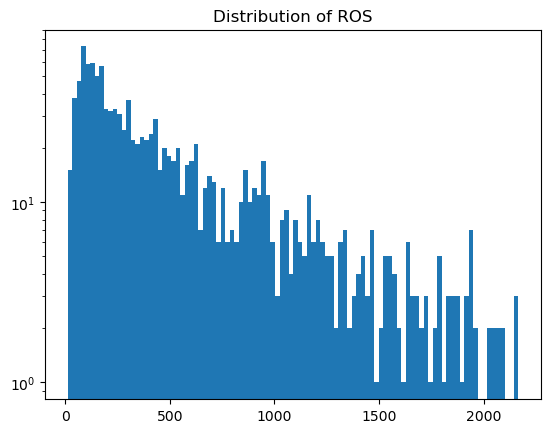

In [26]:
# Plot distribution of y_train_final (ros_p)
plt.hist(y_train_final, bins=100)
plt.yscale('log')
plt.title("Distribution of ROS")
plt.show()

### Create model
(estou a ter problemas a lidar com nans, algumas colunas não têm muitos valores, então prefiro não imputar porque acho que estaria a "falsificar" os dados)

In [27]:
# transform ros_p to log
y_train_log = np.log1p(y_train_final)
y_test_log = np.log1p(y_test_final)

param_dist = {
    'max_depth': [None, 20, 50, 100, 150],        # tree depth
    'min_samples_split': randint(2, 20),          # split number
    'min_samples_leaf': randint(1, 10),           # leave size
    'max_features': ['sqrt', 'log2', 0.5, 0.8, None],  # subset size
    'bootstrap': [True, False],                   # allow testing both sampling methods
    'criterion': ['squared_error', 'absolute_error'],  # MSE vs MAE split criteria
}

base_model = RandomForestRegressor(n_jobs=-1, random_state=42)

tscv = TimeSeriesSplit(n_splits=5)

rf_random = HalvingRandomSearchCV(
    estimator=base_model,
    param_distributions=param_dist,
    factor=3,       # how aggressively to cut poor performers
    resource='n_estimators',
    max_resources=2000,
    min_resources=200,
    scoring='r2',
    cv=tscv,
    n_jobs=-1,
    random_state=42,
    verbose=1
)

# 4. Train the model search
rf_random.fit(X_train_final, y_train_log)

# 5. Get the best model and parameters
print(f"\nSearch complete.")
print(f"Best parameters found: {rf_random.best_params_}")
best_model = rf_random.best_estimator_

# 6. Make predictions with the best model
y_pred_log = best_model.predict(X_test_final)
y_pred = np.expm1(y_pred_log)

# Calculate metrics
r2 = r2_score(y_test_log, y_pred_log)
rmse = np.sqrt(mean_squared_error(y_test_log, y_pred_log))
mae = mean_absolute_error(y_test_log, y_pred_log)

feature_names = X_train_final.columns.tolist()

importances = pd.DataFrame({
    'feature': feature_names,
    'importance': best_model.feature_importances_
})

importances = importances.sort_values('importance', ascending=False)

print("Log scale metrics:")
print(f"R2 Score (log): {r2:.4f}")
print(f"RMSE (log): {rmse:.4f}")
print(f"MAE (log): {mae:.4f}")

n_iterations: 3
n_required_iterations: 3
n_possible_iterations: 3
min_resources_: 200
max_resources_: 2000
aggressive_elimination: False
factor: 3
----------
iter: 0
n_candidates: 10
n_resources: 200
Fitting 5 folds for each of 10 candidates, totalling 50 fits


/opt/anaconda3/lib/python3.13/site-packages/sklearn/model_selection/_validation.py:528: FitFailedWarning: 
35 fits failed out of a total of 50.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
35 fits failed with the following error:
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.13/site-packages/sklearn/model_selection/_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
    ~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/anaconda3/lib/python3.13/site-packages/sklearn/base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "/opt/anaconda3/lib/python3.13/site-packages/sklearn/ensemble/_forest.py", line 375, in fit
    estimator._co

----------
iter: 1
n_candidates: 4
n_resources: 600
Fitting 5 folds for each of 4 candidates, totalling 20 fits


/opt/anaconda3/lib/python3.13/site-packages/sklearn/model_selection/_validation.py:528: FitFailedWarning: 
5 fits failed out of a total of 20.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.13/site-packages/sklearn/model_selection/_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
    ~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/anaconda3/lib/python3.13/site-packages/sklearn/base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "/opt/anaconda3/lib/python3.13/site-packages/sklearn/ensemble/_forest.py", line 375, in fit
    estimator._comp

----------
iter: 2
n_candidates: 2
n_resources: 1800
Fitting 5 folds for each of 2 candidates, totalling 10 fits


/opt/anaconda3/lib/python3.13/site-packages/sklearn/model_selection/_search.py:1108: UserWarning: One or more of the test scores are non-finite: [       nan 0.33065405        nan        nan        nan 0.34095169
        nan 0.33402622        nan        nan        nan 0.3310109
 0.33659606 0.34430826 0.33829358 0.34499425]
  warnings.warn(
/opt/anaconda3/lib/python3.13/site-packages/sklearn/model_selection/_search.py:1108: UserWarning: One or more of the train scores are non-finite: [       nan 0.83456337        nan        nan        nan 0.7910592
        nan 0.68144933        nan        nan        nan 0.83513414
 0.68251944 0.79252942 0.68339655 0.79304853]
  warnings.warn(



Search complete.
Best parameters found: {'bootstrap': True, 'criterion': 'squared_error', 'max_depth': 20, 'max_features': 0.8, 'min_samples_leaf': 3, 'min_samples_split': 13, 'n_estimators': 1800}
Log scale metrics:
R2 Score (log): 0.3803
RMSE (log): 0.8034
MAE (log): 0.6267


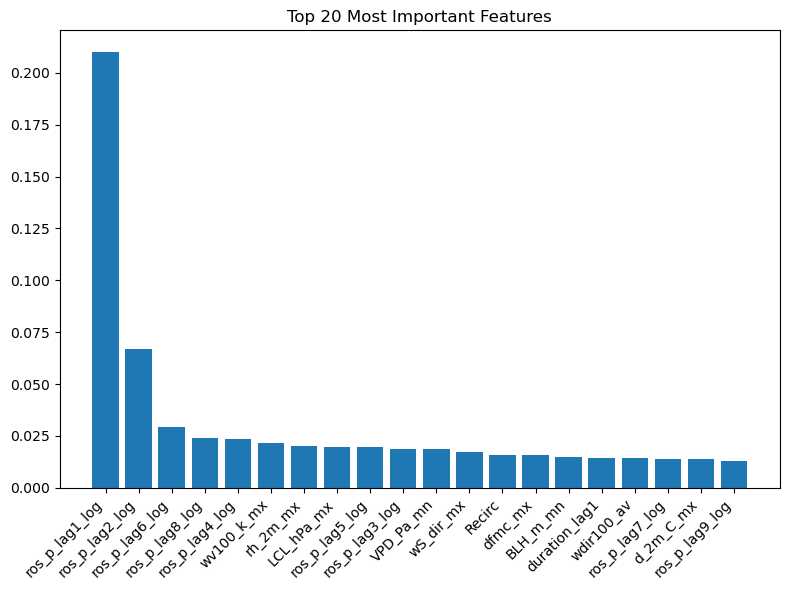


Top 20 Most Important Features:
            feature  importance
116  ros_p_lag1_log    0.209992
117  ros_p_lag2_log    0.067042
121  ros_p_lag6_log    0.029392
123  ros_p_lag8_log    0.023913
119  ros_p_lag4_log    0.023511
18       wv100_k_mx    0.021633
8          rh_2m_mx    0.019954
52       LCL_hPa_mx    0.019828
120  ros_p_lag5_log    0.019819
118  ros_p_lag3_log    0.018898
10        VPD_Pa_mn    0.018706
25        wS_dir_mx    0.017054
65           Recirc    0.015969
64          dfmc_mx    0.015668
42         BLH_m_mn    0.014704
74    duration_lag1    0.014600
19       wdir100_av    0.014592
122  ros_p_lag7_log    0.014033
5         d_2m_C_mx    0.013778
124  ros_p_lag9_log    0.012929


In [28]:
plt.figure(figsize=(8, 6))
plt.bar(importances['feature'][:20], importances['importance'][:20])
plt.xticks(rotation=45, ha='right')
plt.title(f'Top 20 Most Important Features')
plt.tight_layout()
plt.show()

print("\nTop 20 Most Important Features:")
print(importances.head(20))

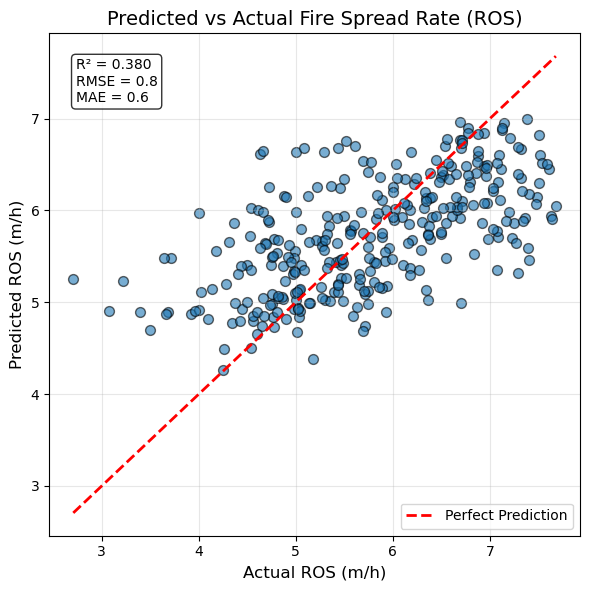

In [29]:
# Predicted vs Actual scatter plot
plt.figure(figsize=(6, 6))
plt.scatter(y_test_log, y_pred_log, alpha=0.6, edgecolor='k', s=50)

# Perfect prediction line
min_val = min(y_test_log.min(), y_pred_log.min())
max_val = max(y_test_log.max(), y_pred_log.max())
plt.plot([min_val, max_val], [min_val, max_val], 'r--', linewidth=2, label='Perfect Prediction')

plt.title('Predicted vs Actual Fire Spread Rate (ROS)', fontsize=14)
plt.xlabel('Actual ROS (m/h)', fontsize=12)
plt.ylabel('Predicted ROS (m/h)', fontsize=12)

# Add metrics annotation
plt.text(0.05, 0.95, f'R² = {r2:.3f}\nRMSE = {rmse:.1f}\nMAE = {mae:.1f}', 
         transform=plt.gca().transAxes, verticalalignment='top',
         bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [30]:
# 1. Create a small DataFrame with actual vs predicted
sample_df = pd.DataFrame({
    'Actual': y_test_final,
    'Predicted': y_pred
}).reset_index(drop=True)

# 2. Randomly sample 10 rows
sample_10 = sample_df.sample(10).copy()

# 3. Compute % error (symmetric MAPE-style for clarity)
sample_10['% Error'] = ((sample_10['Predicted'] - sample_10['Actual']) / sample_10['Actual']) * 100

# 4. Format nicely
sample_10['% Error'] = sample_10['% Error'].round(2)

# 5. Display
print("Sample of 10 predictions vs actual values:\n")
display(sample_10)

Sample of 10 predictions vs actual values:



,Actual,Predicted,% Error
166,115.061665,241.330237,109.74
267,168.900386,286.245290,69.48
272,81.126623,201.179210,147.98
314,569.292580,446.822582,-21.51
109,697.858291,349.616751,-49.90
27,64.174637,257.857843,301.81
216,712.762572,671.425183,-5.80
202,70.965802,179.357026,152.74
102,1135.274532,497.400086,-56.19
176,38.040289,129.731353,241.04


### Use linear scale

n_iterations: 3
n_required_iterations: 3
n_possible_iterations: 3
min_resources_: 200
max_resources_: 2000
aggressive_elimination: False
factor: 3
----------
iter: 0
n_candidates: 10
n_resources: 200
Fitting 5 folds for each of 10 candidates, totalling 50 fits


/opt/anaconda3/lib/python3.13/site-packages/sklearn/model_selection/_validation.py:528: FitFailedWarning: 
10 fits failed out of a total of 50.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
10 fits failed with the following error:
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.13/site-packages/sklearn/model_selection/_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
    ~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/anaconda3/lib/python3.13/site-packages/sklearn/base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "/opt/anaconda3/lib/python3.13/site-packages/sklearn/ensemble/_forest.py", line 375, in fit
    estimator._co

----------
iter: 1
n_candidates: 4
n_resources: 600
Fitting 5 folds for each of 4 candidates, totalling 20 fits


/opt/anaconda3/lib/python3.13/site-packages/sklearn/model_selection/_search.py:1108: UserWarning: One or more of the test scores are non-finite: [ 0.30235217  0.2826426          nan  0.2967121  -0.03787579  0.29616765
  0.29404351         nan  0.31640873  0.30613292  0.29691964  0.29744966
  0.30531981  0.31642702]
  warnings.warn(
/opt/anaconda3/lib/python3.13/site-packages/sklearn/model_selection/_search.py:1108: UserWarning: One or more of the train scores are non-finite: [0.64432597 0.79467949        nan 0.86982277 0.71952918 0.56377853
 0.66273197        nan 0.70212076 0.60770357 0.87250163 0.64433201
 0.60849775 0.70462293]
  warnings.warn(


----------
iter: 2
n_candidates: 2
n_resources: 1800
Fitting 5 folds for each of 2 candidates, totalling 10 fits


/opt/anaconda3/lib/python3.13/site-packages/sklearn/model_selection/_search.py:1108: UserWarning: One or more of the test scores are non-finite: [ 0.30235217  0.2826426          nan  0.2967121  -0.03787579  0.29616765
  0.29404351         nan  0.31640873  0.30613292  0.29691964  0.29744966
  0.30531981  0.31642702  0.30402129  0.31542122]
  warnings.warn(
/opt/anaconda3/lib/python3.13/site-packages/sklearn/model_selection/_search.py:1108: UserWarning: One or more of the train scores are non-finite: [0.64432597 0.79467949        nan 0.86982277 0.71952918 0.56377853
 0.66273197        nan 0.70212076 0.60770357 0.87250163 0.64433201
 0.60849775 0.70462293 0.60924272 0.70548445]
  warnings.warn(



Search complete.
Best parameters found: {'bootstrap': False, 'criterion': 'squared_error', 'max_depth': 50, 'max_features': 'sqrt', 'min_samples_leaf': 8, 'min_samples_split': 19, 'n_estimators': 1800}

Linear scale metrics:
R2 Score: 0.3014
RMSE: 404.7100
MAE: 280.6486


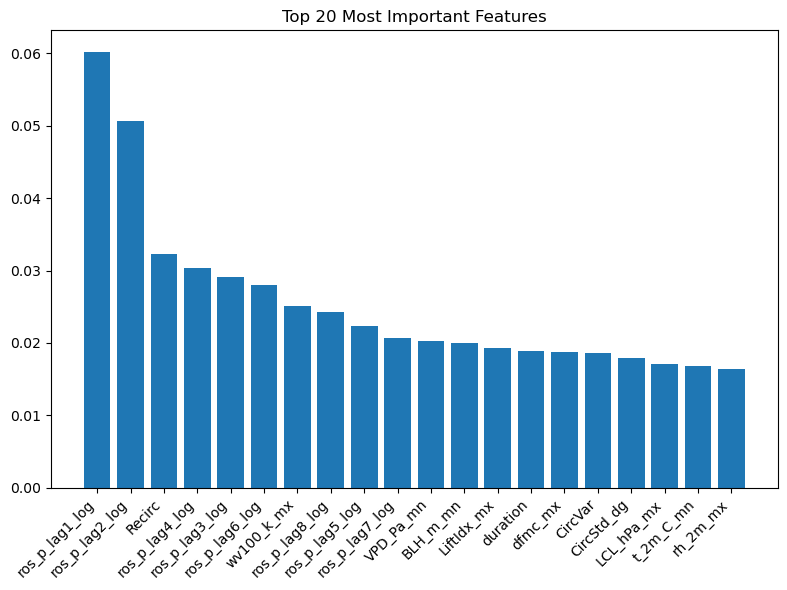


Top 20 Most Important Features:
           feature  importance
0   ros_p_lag1_log    0.060167
1   ros_p_lag2_log    0.050618
2           Recirc    0.032237
3   ros_p_lag4_log    0.030308
4   ros_p_lag3_log    0.029167
5   ros_p_lag6_log    0.028038
6       wv100_k_mx    0.025124
7   ros_p_lag8_log    0.024224
8   ros_p_lag5_log    0.022338
9   ros_p_lag7_log    0.020666
10       VPD_Pa_mn    0.020313
11        BLH_m_mn    0.019937
12      LiftIdx_mx    0.019241
13        duration    0.018876
14         dfmc_mx    0.018744
15         CircVar    0.018651
16      CircStd_dg    0.017870
17      LCL_hPa_mx    0.017123
18       t_2m_C_mn    0.016886
19        rh_2m_mx    0.016468


In [31]:
# -----------------------------------------
# 1. Use linear targets (no log transformation)
# -----------------------------------------
y_train_linear = y_train_final.copy()
y_test_linear = y_test_final.copy()

# -----------------------------------------
# 2. Hyperparameter distribution
# -----------------------------------------
param_dist = {
    'max_depth': [None, 20, 50, 100, 150],        # allow deeper trees
    'min_samples_split': randint(2, 20),          # explore more splits
    'min_samples_leaf': randint(1, 10),           # test smaller and larger leaves
    'max_features': ['sqrt', 'log2', 0.5, 0.8, None],  # let it use a larger subset
    'bootstrap': [True, False],                   # allow testing both sampling methods
    'criterion': ['squared_error', 'absolute_error'],  # MSE vs MAE split criteria
}

# 3. Set up RandomizedSearchCV
# Initialize the base model
base_model = RandomForestRegressor(n_jobs=-1) #random_state=42

tscv = TimeSeriesSplit(n_splits=5)

rf_random = HalvingRandomSearchCV(
    estimator=base_model,
    param_distributions=param_dist,
    factor=3,       # how aggressively to cut poor performers
    resource='n_estimators',
    max_resources=2000,
    min_resources=200,
    scoring='r2',
    cv=tscv,
    n_jobs=-1,
    verbose=1
)

rf_random.fit(X_train_final, y_train_linear)

# -----------------------------------------
# 4. Get best model and predictions
# -----------------------------------------
print(f"\nSearch complete.")
print(f"Best parameters found: {rf_random.best_params_}")
best_model = rf_random.best_estimator_

y_pred_linear = best_model.predict(X_test_final)

# -----------------------------------------
# 5. Calculate metrics on linear scale
# -----------------------------------------
r2_linear = r2_score(y_test_linear, y_pred_linear)
rmse_linear = np.sqrt(mean_squared_error(y_test_linear, y_pred_linear))
mae_linear = mean_absolute_error(y_test_linear, y_pred_linear)

print("\nLinear scale metrics:")
print(f"R2 Score: {r2_linear:.4f}")
print(f"RMSE: {rmse_linear:.4f}")
print(f"MAE: {mae_linear:.4f}")

# -----------------------------------------
# 6. Feature importances
# -----------------------------------------
feature_names = X_train_final.columns.tolist()

importances = pd.DataFrame({
    'feature': feature_names,
    'importance': best_model.feature_importances_
})

importances = importances.sort_values(by='importance', ascending=False).reset_index(drop=True)

plt.figure(figsize=(8, 6))
plt.bar(importances['feature'][:20], importances['importance'][:20])
plt.xticks(rotation=45, ha='right')
plt.title('Top 20 Most Important Features')
plt.tight_layout()
plt.show()

print("\nTop 20 Most Important Features:")
print(importances.head(20))

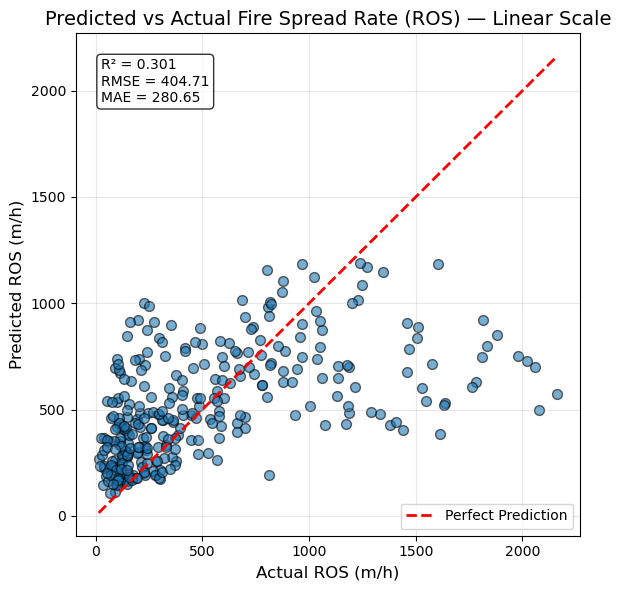

In [32]:
# Predicted vs Actual scatter plot for new linear-target model
plt.figure(figsize=(6, 6))
plt.scatter(y_test_linear, y_pred_linear, alpha=0.6, edgecolor='k', s=50)

# Perfect prediction line
min_val = min(y_test_linear.min(), y_pred_linear.min())
max_val = max(y_test_linear.max(), y_pred_linear.max())
plt.plot([min_val, max_val], [min_val, max_val], 'r--', linewidth=2, label='Perfect Prediction')

plt.title('Predicted vs Actual Fire Spread Rate (ROS) — Linear Scale', fontsize=14)
plt.xlabel('Actual ROS (m/h)', fontsize=12)
plt.ylabel('Predicted ROS (m/h)', fontsize=12)

# Add metrics annotation (linear-scale metrics)
plt.text(0.05, 0.95, f'R² = {r2_linear:.3f}\nRMSE = {rmse_linear:.2f}\nMAE = {mae_linear:.2f}', 
         transform=plt.gca().transAxes, verticalalignment='top',
         bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [33]:
# 1. Create a small DataFrame with actual vs predicted (linear model)
sample_df = pd.DataFrame({
    'Actual': y_test_linear,
    'Predicted': y_pred_linear
}).reset_index(drop=True)

# 2. Randomly sample 10 rows
sample_10 = sample_df.sample(10).copy()

# 3. Compute % error
sample_10['% Error'] = ((sample_10['Predicted'] - sample_10['Actual']) / sample_10['Actual']) * 100

# 4. Format nicely
sample_10['% Error'] = sample_10['% Error'].round(2)

# 5. Display
print("Sample of 10 predictions vs actual values (linear model):\n")
display(sample_10)

Sample of 10 predictions vs actual values (linear model):



,Actual,Predicted,% Error
315,287.892007,258.573868,-10.18
73,99.962793,534.595408,434.79
106,303.002641,216.534574,-28.54
256,196.878070,919.009058,366.79
5,482.652128,514.942198,6.69
81,508.418438,713.160386,40.27
72,329.895764,331.047017,0.35
76,1835.577481,800.392193,-56.40
185,260.533577,411.314053,57.87
241,330.948150,322.757254,-2.47


Exception ignored in: <function ResourceTracker.__del__ at 0x106c39bc0>
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 82, in __del__
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 91, in _stop
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 116, in _stop_locked
ChildProcessError: [Errno 10] No child processes
Exception ignored in: <function ResourceTracker.__del__ at 0x11006dbc0>
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 82, in __del__
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 91, in _stop
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 116, in _stop_locked
ChildProcessError: [Errno 10] No child processes
Exception ignored in: <function ResourceTracker.__del__ at 0x106b4dbc0>
Traceback (most recent call last